In [ ]:
%%capture

!pip install pafy youtube-dl moviepy

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import random
import pafy
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar

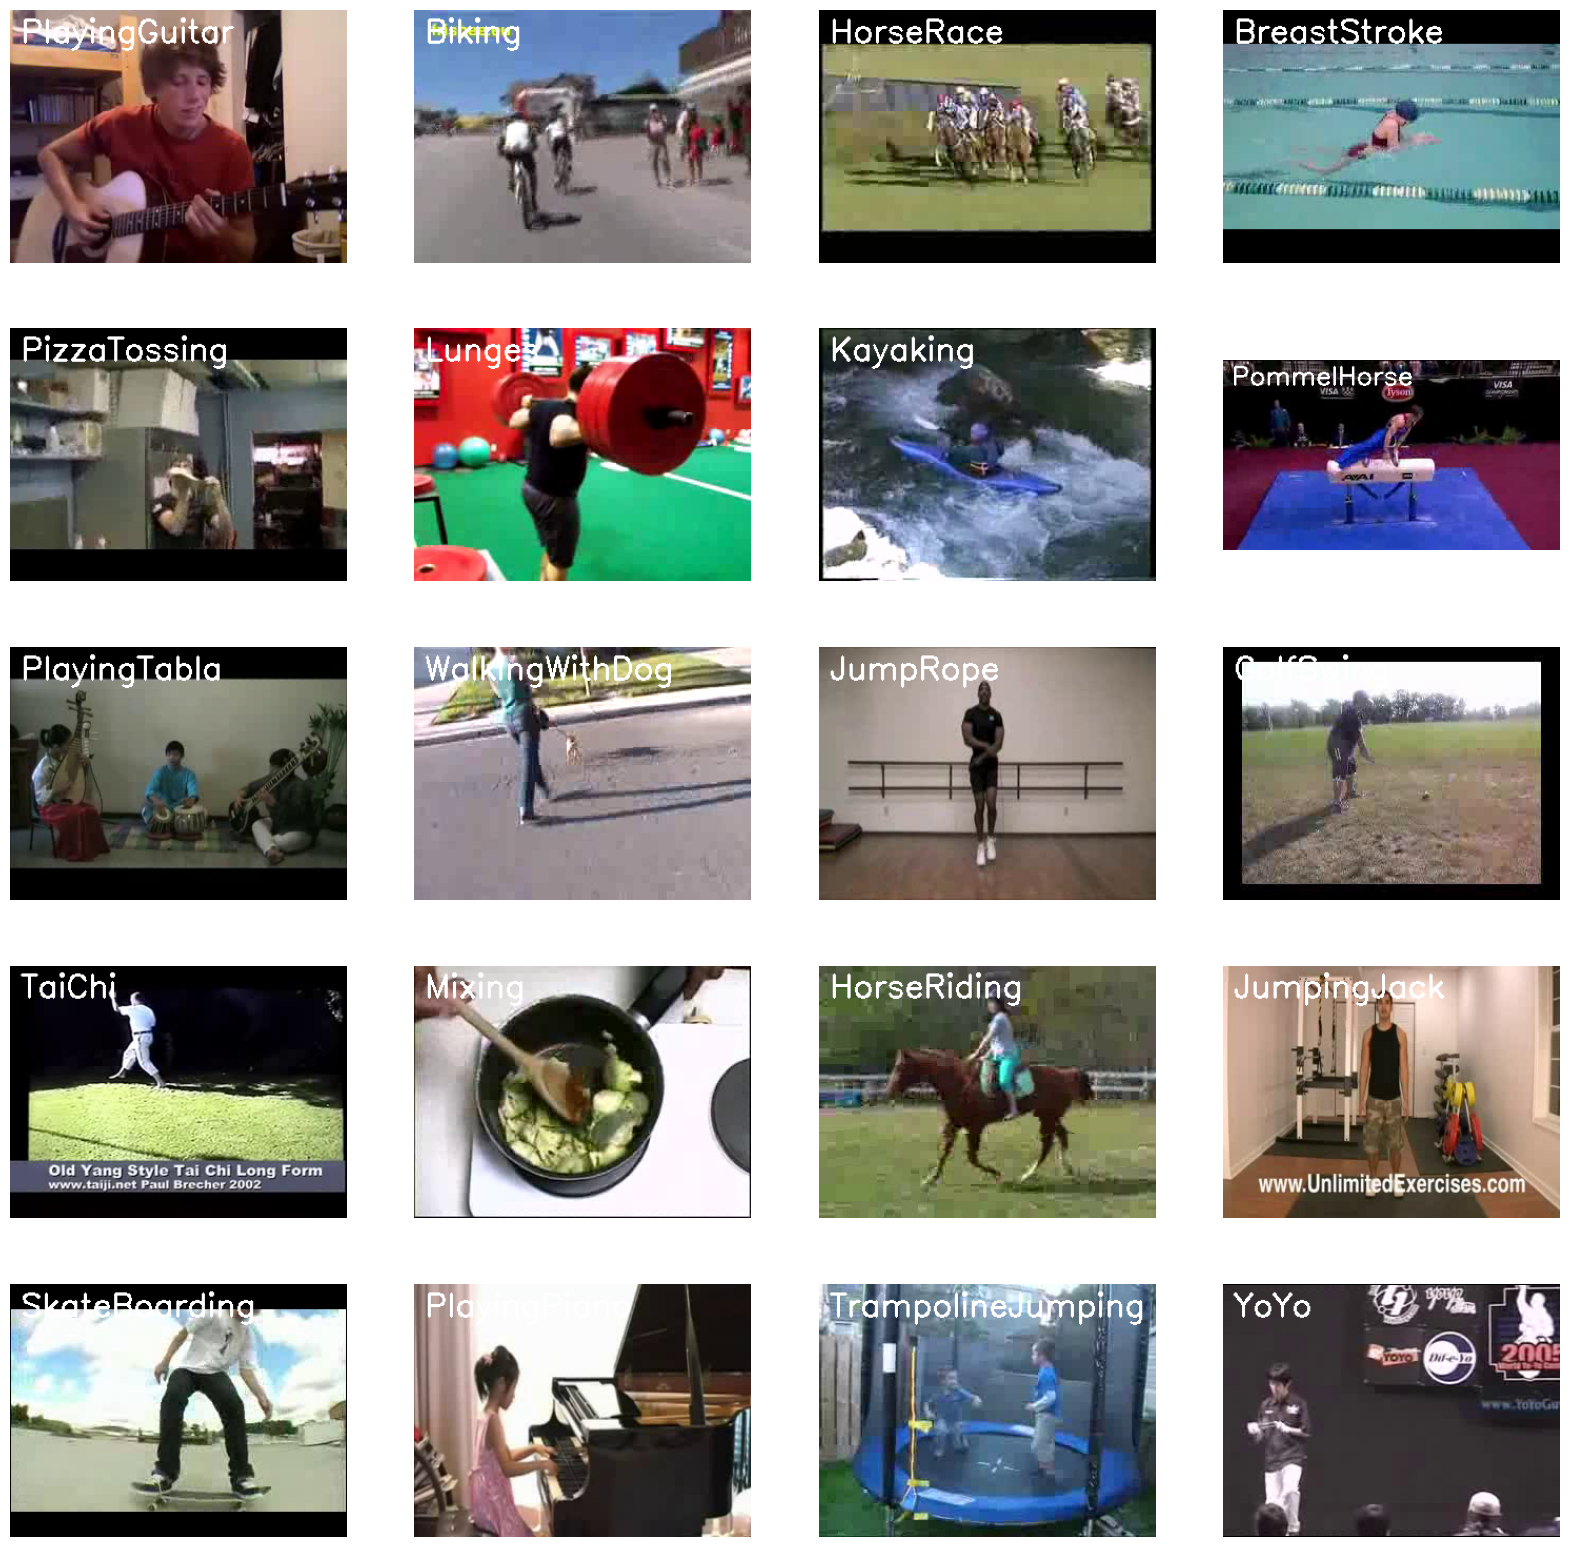

In [ ]:
plt.figure(figsize=(20,20))

all_classes_names=os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)),20)

for counter, random_index in enumerate(random_range, 1):

  selected_class_Name = all_classes_names[random_index]

  video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  _,bgr_frame = video_reader.read()

  video_reader.release()

  rgb_frame = cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame,selected_class_Name,(10,30),cv2.FONT_HERSHEY_SIMPLEX ,1,(255, 255, 255),2)

  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')


In [ ]:
IMAGE_HEIGHT,IMAGE_WIDTH = 64,64

SEQUENCE_LENGTH = 20

DATASET_DIR = 'UCF50'

CLASSES_LIST= ['WalkingWithDog','TaiChi','Swing','HorseRace']

In [ ]:
def frames_extraction(video_path):

  frames_list=[]

  video_reader = cv2.VideoCapture(video_path)

  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):

    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter * skip_frames_window)

    success,frame = video_reader.read()

    if not success:
      break

    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

    normalized_frame = resized_frame / 255

    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

In [ ]:
def create_dataset():

  features = []
  labels = []
  video_files_paths = []

  for class_index,class_name in enumerate(CLASSES_LIST):

    print(f'Extracting Data of Class:{class_name}')

    files_list = os.listdir(os.path.join(DATASET_DIR,class_name))

    for file_name in files_list:

      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)

      frames = frames_extraction(video_file_path)

      if len(frames) == SEQUENCE_LENGTH:

        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)


  features = np.asarray(features)
  labels = np.array(labels)

  return features,labels,video_files_paths

In [ ]:
features,labels,video_files_paths = create_dataset()

Extracting Data of Class:WalkingWithDog
Extracting Data of Class:TaiChi
Extracting Data of Class:Swing
Extracting Data of Class:HorseRace


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train,features_test,labels_train,labels_test = train_test_split(features,one_hot_encoded_labels,
                                                                         test_size=0.25,shuffle = True,
                                                                         random_state = seed_constant)

In [ ]:
def create_Convlstm_model():

    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3,3), activation = 'tanh',data_format = 'channels_last',
                         recurrent_dropout = 0.2, return_sequences=True,input_shape=(SEQUENCE_LENGTH,
                                                                                    IMAGE_HEIGHT,IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding= 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))


    model.add(ConvLSTM2D(filters = 8,kernel_size=(3,3),activation='tanh',data_format = 'channels_last',
                         recurrent_dropout = 0.2,return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14,kernel_size = (3,3),activation='tanh',data_format = 'channels_last',
                         recurrent_dropout = 0.2,return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16,kernel_size = (3, 3),activation='tanh',data_format = 'channels_last',
                         recurrent_dropout = 0.2,return_sequences=True))


    model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))


    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST),activation = 'softmax'))

    model.summary()

    return model

In [ ]:
Convlstm_model = create_Convlstm_model()

print('Model Created Successfully')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

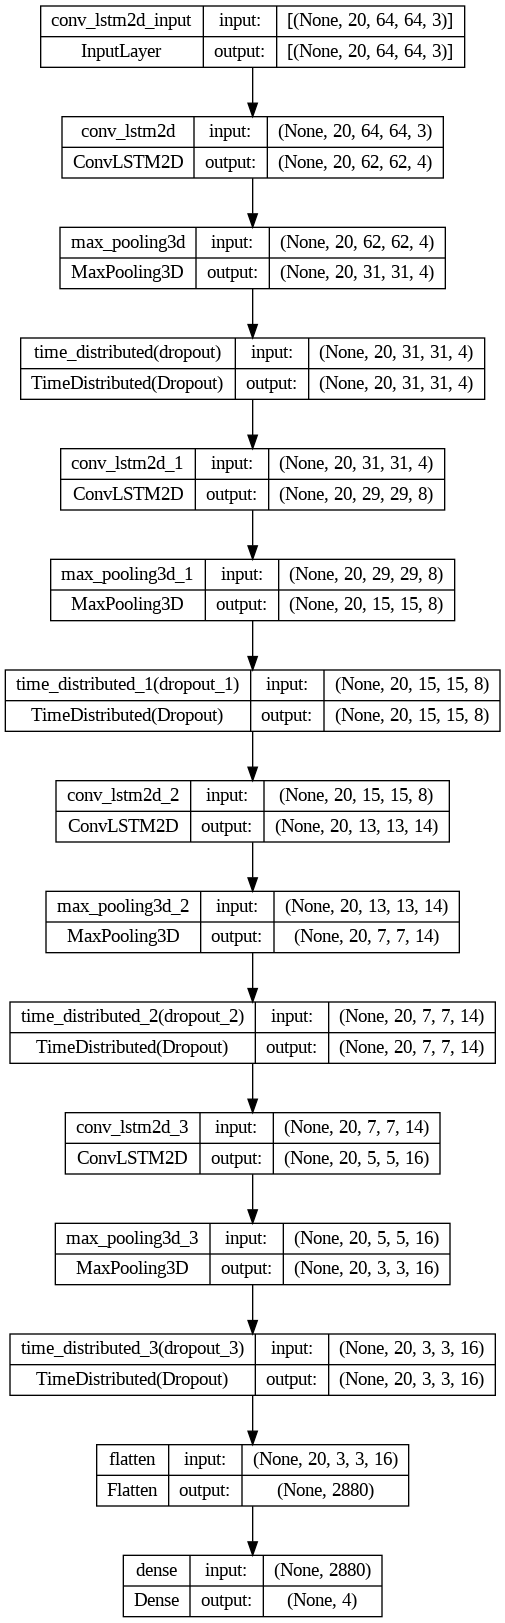

In [ ]:
plot_model(Convlstm_model,to_file = 'convlstm_model_structure_plot.png',show_shapes = True,show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience = 10,mode='min',restore_best_weights = True)

Convlstm_model.compile(loss='categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])

convlstm_model_training_history = Convlstm_model.fit(x = features_train ,y=labels_train,epochs = 10,batch_size=4,
                                                     shuffle = True,validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])



Epoch 1/10
73/73 [==============================] - 169s 2s/step - loss: 1.3930 - accuracy: 0.2432 - val_loss: 1.3733 - val_accuracy: 0.3288
Epoch 2/10
73/73 [==============================] - 174s 2s/step - loss: 1.3628 - accuracy: 0.3527 - val_loss: 1.2995 - val_accuracy: 0.4384
Epoch 3/10
73/73 [==============================] - 169s 2s/step - loss: 1.2094 - accuracy: 0.4932 - val_loss: 1.1544 - val_accuracy: 0.5342
Epoch 4/10
73/73 [==============================] - 157s 2s/step - loss: 1.0617 - accuracy: 0.6062 - val_loss: 1.3309 - val_accuracy: 0.4110
Epoch 5/10
73/73 [==============================] - 168s 2s/step - loss: 0.9618 - accuracy: 0.5993 - val_loss: 1.0173 - val_accuracy: 0.5479
Epoch 6/10
73/73 [==============================] - 158s 2s/step - loss: 0.8366 - accuracy: 0.6644 - val_loss: 1.0487 - val_accuracy: 0.5890
Epoch 7/10
73/73 [==============================] - 172s 2s/step - loss: 0.6260 - accuracy: 0.7329 - val_loss: 0.9151 - val_accuracy: 0.6575
Epoch 8/10
73

In [ ]:
model_evaluation_history = Convlstm_model.evaluate(features_test,labels_test)

4/4 [==============================] - 17s 4s/step - loss: 0.8411 - accuracy: 0.7623


In [ ]:
model_evaluation_loss,model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name = f'Convlstm_model__Date_time_{current_date_time_string}__loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

Convlstm_model.save(model_file_name)


In [ ]:
def plot_metric(model_training_history,metric_name_1,metric_name_2,plot_name):

  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue',label = metric_value_1)
  plt.plot(epochs, metric_value_2, 'red',label = metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

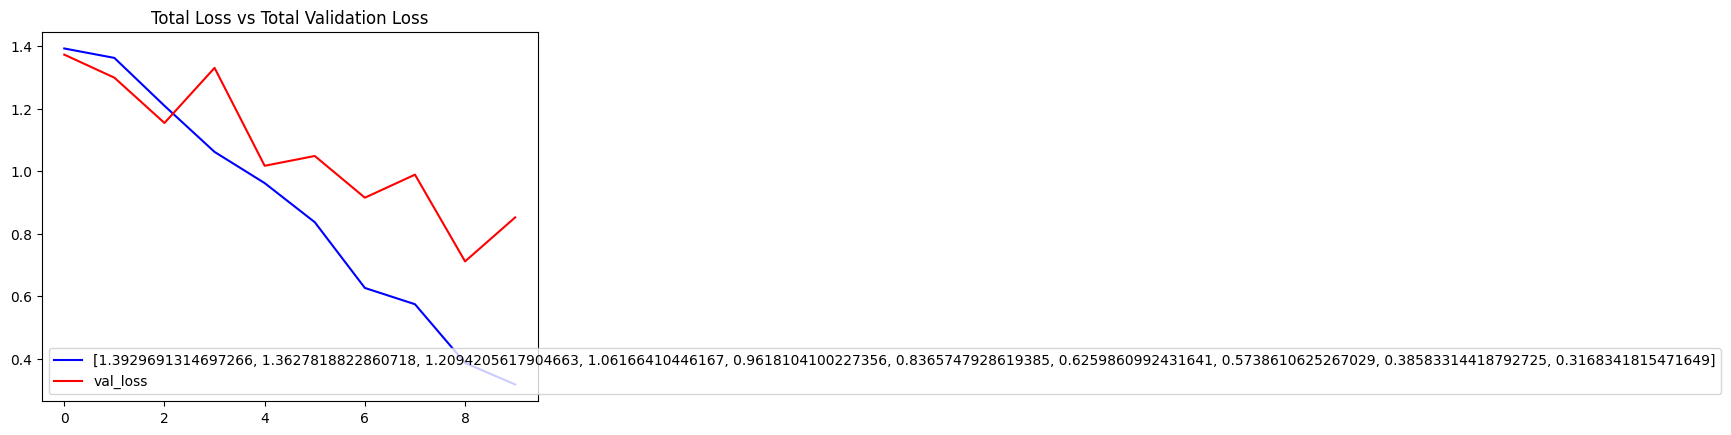

In [ ]:
plot_metric(convlstm_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')

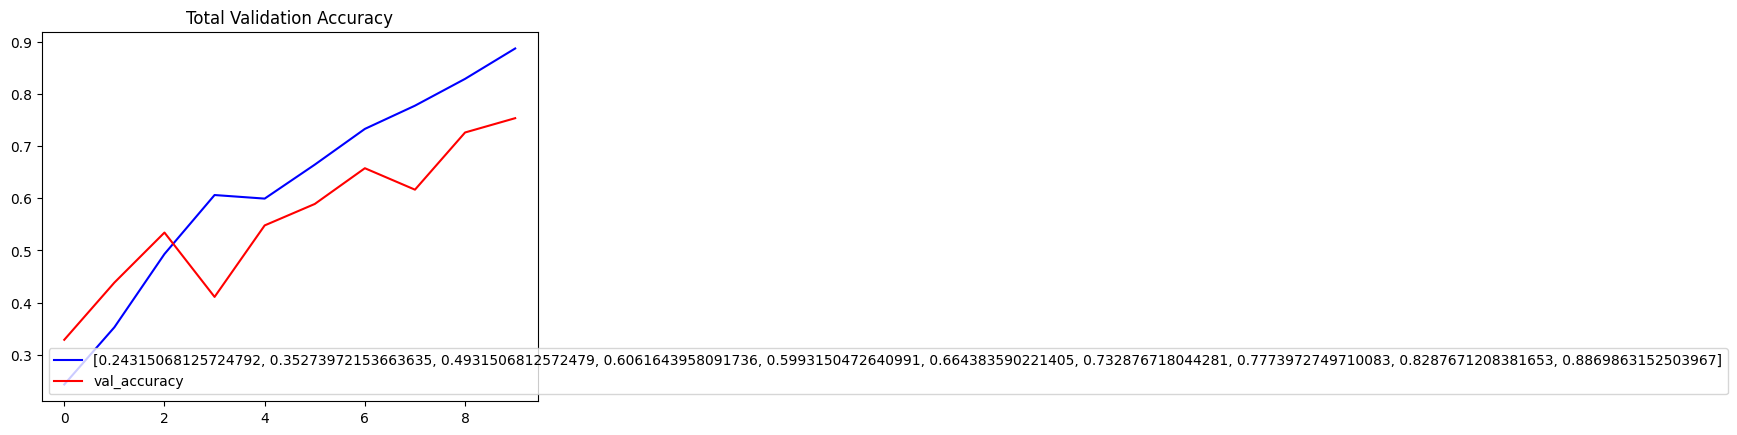

In [ ]:
plot_metric(convlstm_model_training_history,'accuracy','val_accuracy','Total Validation Accuracy')

In [ ]:
def create_LRCN_model():

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16,(3,3),padding = 'same',activation = 'relu'),input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT , IMAGE_WIDTH,3)))

    model.add(TimeDistributed(MaxPooling2D(4,4)))
    model.add(TimeDistributed(Dropout(0.25)))



    model.add(TimeDistributed(Conv2D(32,(3,3),padding = 'same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(4,4)))
    model.add(TimeDistributed(Dropout(0.25)))


    model.add(TimeDistributed(Conv2D(64,(3,3),padding = 'same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64,(3,3),padding = 'same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST),activation = 'softmax'))

    model.summary()

    return model


In [ ]:
LRCN_model = create_LRCN_model()

print('Model Created Successfully')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 20, 4, 4, 32)    

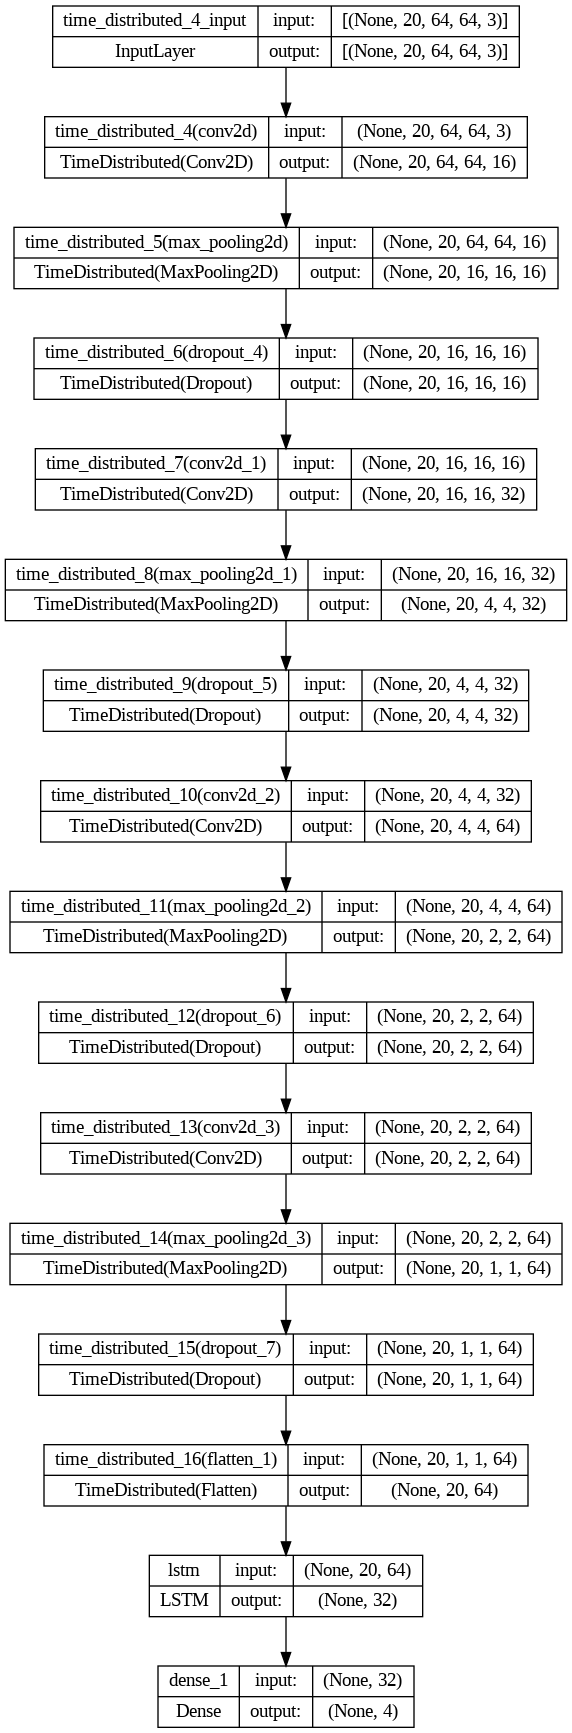

In [ ]:
plot_model(LRCN_model , to_file = 'LRCN_model_structure_plot.png',show_shapes = True,show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss',patience = 15,mode = 'min',restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])

LRCN_model_training_history = LRCN_model.fit(x = features_train,y = labels_train,epochs = 10,batch_size = 4,shuffle = True,validation_split = 0.2,
                                             callbacks = [early_stopping_callback])

Epoch 1/10
73/73 [==============================] - 24s 283ms/step - loss: 1.4136 - accuracy: 0.2842 - val_loss: 1.3674 - val_accuracy: 0.3562
Epoch 2/10
73/73 [==============================] - 16s 222ms/step - loss: 1.3561 - accuracy: 0.2979 - val_loss: 1.3672 - val_accuracy: 0.3288
Epoch 3/10
73/73 [==============================] - 16s 221ms/step - loss: 1.2671 - accuracy: 0.3836 - val_loss: 1.1810 - val_accuracy: 0.4521
Epoch 4/10
73/73 [==============================] - 16s 219ms/step - loss: 1.1225 - accuracy: 0.4760 - val_loss: 1.0596 - val_accuracy: 0.6712
Epoch 5/10
73/73 [==============================] - 16s 220ms/step - loss: 0.9749 - accuracy: 0.5993 - val_loss: 0.9936 - val_accuracy: 0.6027
Epoch 6/10
73/73 [==============================] - 19s 258ms/step - loss: 0.9172 - accuracy: 0.6233 - val_loss: 1.0245 - val_accuracy: 0.6438
Epoch 7/10
73/73 [==============================] - 16s 219ms/step - loss: 0.7716 - accuracy: 0.6815 - val_loss: 0.8523 - val_accuracy: 0.7397

In [ ]:
model_evaluate_history = LRCN_model.evaluate(features_test , labels_test)

4/4 [==============================] - 2s 493ms/step - loss: 0.6427 - accuracy: 0.7541


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt,date_time_format)

model_file_name = f'LRCN_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

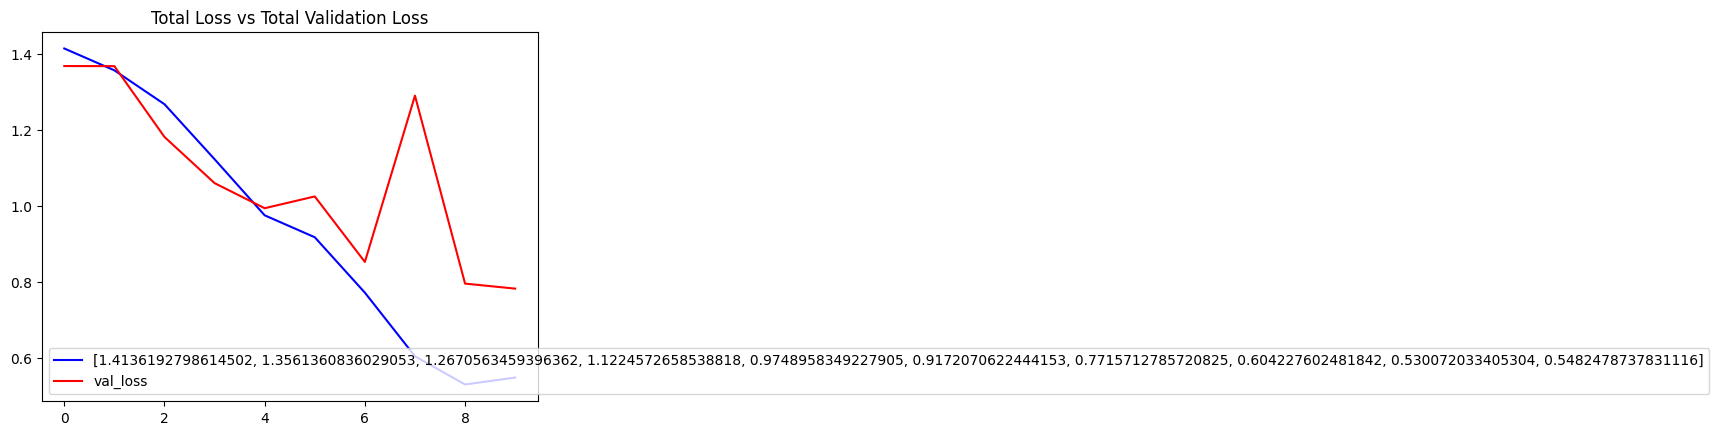

In [ ]:
plot_metric(LRCN_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')

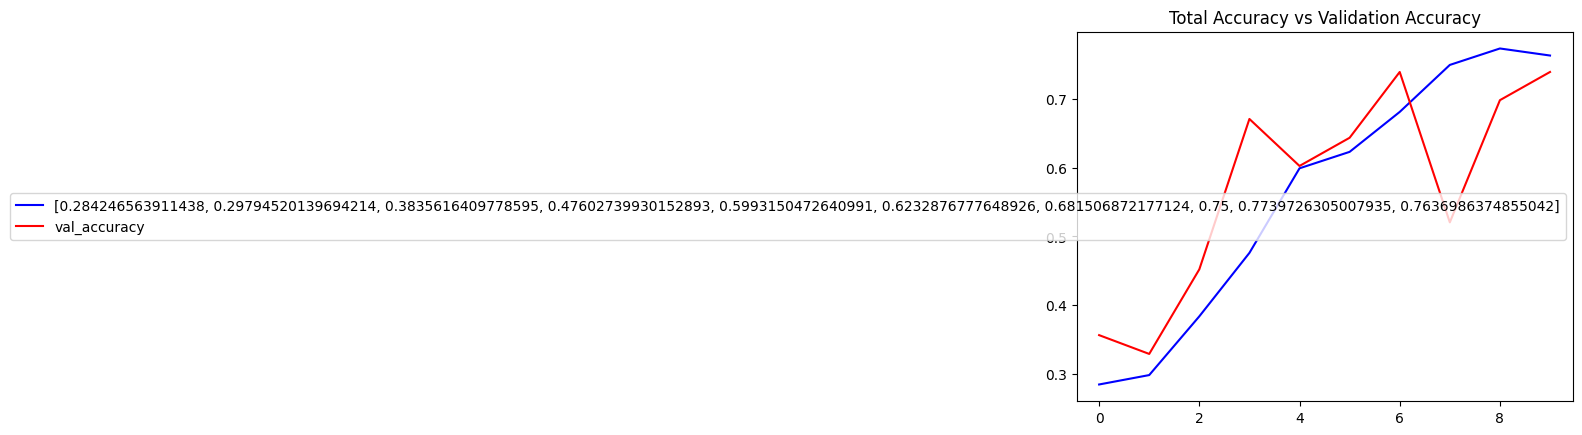

In [ ]:
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Validation Accuracy')